# <span style="color:blue;">Notebook Contents</span>

## 1. Importing Packages

## 2. Loading Preparation
  1. **Data loading**
  2. **Encoding**

## 3. Training and Evaluating the Models
  1. **Training and tracking Decision Tree, Logistic Regression and SVM**
  
## 4. Model Evaluation using AUC-PR score

## 1. Importing packages

In [24]:
# common imports
import os
import ast
import time
from collections import Counter
import pandas as pd
import numpy as np

# for pretty plots
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

# global settings
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure',figsize=(8,6))

# shuffle
from sklearn.utils import shuffle

# pipleline
from sklearn.pipeline import make_pipeline, Pipeline

# feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# feature scaling
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# classifiers
from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# model selection
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, GridSearchCV, PredefinedSplit

# metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score, f1_score 
from sklearn.metrics import classification_report, make_scorer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc,roc_curve, roc_auc_score, PrecisionRecallDisplay

# mlflow
import mlflow
import mlflow.sklearn

In [3]:
# Ingore warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## 2. Data Preparation

### Loading the data

In [8]:
train = pd.read_csv('./dvc_store/train.csv')
validation = pd.read_csv('./dvc_store/validation.csv')
test = pd.read_csv('./dvc_store/test.csv')

### Encoding the data

In [4]:
encoder = LabelEncoder()
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.8, stop_words="english")

def features_label_vectorization(df, is_train=True):
    X = df['Tokens']
    y = df['Label']

    if is_train:
        features = vectorizer.fit_transform(X)  
        label = encoder.fit_transform(y)  
        
    else:
        features = vectorizer.transform(X) 
        label = encoder.transform(y) 

    return features, label

In [11]:
encoder = LabelEncoder()
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.8, stop_words="english")

def features_label_vectorization(df, is_train=True):
    X = df['Tokens']
    y = df['Label']

    if is_train:
        features = vectorizer.fit_transform(X)  
        label = encoder.fit_transform(y)  
        
    else:
        features = vectorizer.transform(X) 
        label = encoder.transform(y) 

    return features, label

In [19]:
X_tr, y_tr = features_label_vectorization(train, is_train=True)
X_val, y_val = features_label_vectorization(validation, is_train=False)
X_test, y_test = features_label_vectorization(test, is_train=False)

In [36]:
X_test, y_test = features_label_vectorization(test, is_train=False)

## 3. Model training and tracking

### Three models
   1.**Decision**
   2.**Logistic Regression**
   3.**SVM**

In [20]:
# Models

# Decision Tree
dt_clf = DecisionTreeClassifier(class_weight='balanced', max_depth=20, random_state=42)

# Logistic Regression
sgd_clf = SGDClassifier(loss='log_loss', penalty='l2', alpha=0.0001, learning_rate='constant',
                        eta0=0.01, warm_start=True, max_iter=1000, random_state=42)

# Support Vector Machine
svm_clf = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)

In [21]:
# model metrics

def model_eval_metrics(y, y_pred, y_proba, model_name, data_set_name):
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, pos_label=1)
    recall = recall_score(y, y_pred, pos_label=1)
    f1 = f1_score(y, y_pred, pos_label=1)
    aucpr = average_precision_score(y, y_proba) if y_proba is not None else np.nan

    return {
        "Model": model_name,
        "Dataset": data_set_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "AUC PR": aucpr
    }

In [32]:
# Function to train and evaluate models
def train_and_evaluate_models(X_train, y_train):
    models = {
        "Decision Tree": dt_clf,
        "Logistic Regression (SGD)": sgd_clf,
        "SVM": svm_clf
    }
    
    results = []
    
    mlflow.set_experiment("Spam Classification Experiment")
    
    for model_name, model in models.items():
        with mlflow.start_run(run_name=model_name):
            model.fit(X_train, y_train)
            y_pred = model.predict(X_train)
            y_proba = model.predict_proba(X_train)[:, 1] if hasattr(model, "predict_proba") else None
            
            metrics = model_eval_metrics(y_train, y_pred, y_proba, model_name, "Training")
            results.append(metrics)
            
            # Log metrics to MLflow
            mlflow.log_param("model_name", model_name)
            mlflow.log_metric("accuracy", metrics["Accuracy"])
            mlflow.log_metric("precision", metrics["Precision"])
            mlflow.log_metric("recall", metrics["Recall"])
            mlflow.log_metric("f1_score", metrics["F1 Score"])
            mlflow.log_metric("auc_pr", metrics["AUC PR"])
            
            # Log model to MLflow
            input_example = X_train[:1]
            mlflow.sklearn.log_model(model, model_name, input_example=input_example)
    
    df_results = pd.DataFrame(results)
    return df_results

In [33]:
results = train_and_evaluate_models(X_tr, y_tr)
results

,Model,Dataset,Accuracy,Precision,Recall,F1 Score,AUC PR
0,Decision Tree,Training,0.983450,0.976190,0.893246,0.932878,0.906162
1,Logistic Regression (SGD),Training,0.968303,0.991477,0.760349,0.860666,0.979938
2,SVM,Training,0.996914,1.000000,0.976035,0.987872,0.999991


## 4. Model Scoring using AUC-PR score on test data

In [83]:
def plot_precision_recall_curves(X_test, y_test):
    runs = mlflow.search_runs(order_by=['start_time desc'])
    auc_pr_scores = {}
    
    plt.figure(figsize=(6, 4))
    
    for _, row in runs.iterrows():
        model_name = row['tags.mlflow.runName']
        if model_name in auc_pr_scores:
            continue  # Avoid duplicate model entries
        
        logged_model = f"runs:/{row['run_id']}/{model_name}"
        model = mlflow.sklearn.load_model(logged_model)
        
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
        
        if y_proba is not None:
            precision, recall, _ = precision_recall_curve(y_test, y_proba)
            auc_pr = average_precision_score(y_test, y_proba)
            auc_pr_scores[model_name] = auc_pr
            plt.plot(recall, precision, marker='.', label=model_name)
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Models')
    plt.legend()
    plt.show()
    
    # Bar chart for AUC-PR scores
    plt.figure(figsize=(6, 4))
    plt.bar(auc_pr_scores.keys(), auc_pr_scores.values(), color=['red', 'blue', 'purple'])
    plt.xlabel('Model', fontsize=10)
    plt.xticks(fontsize=8)
    plt.ylabel('AUC-PR')
    plt.title('AUC-PR Scores for Models')
    plt.show()

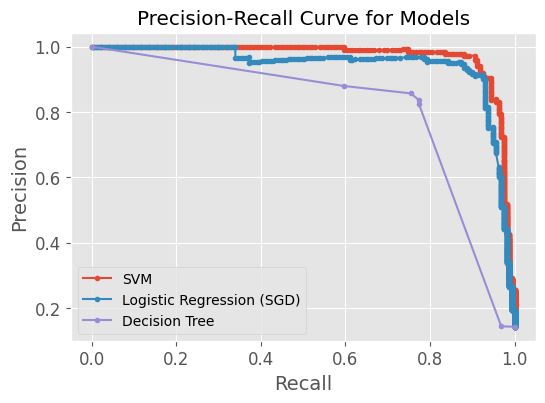

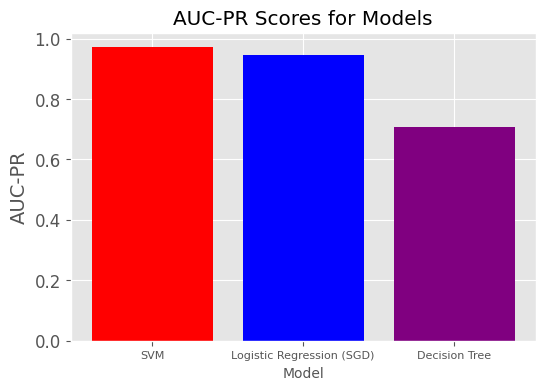

In [84]:
plot_precision_recall_curves(X_test, y_test)